In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
dataset = []
label = []

In [4]:
Glaucoma_dir = os.path.join(r"C:\Users\USER\CNNdatsets\Glaucoma")
Non_Glaucoma_dir = os.path.join(r"C:\Users\USER\CNNdatsets\Non Glaucoma")

In [5]:
parasitized_images = os.listdir(Glaucoma_dir)
for i, image_name in enumerate(parasitized_images):
    try:
        if (image_name.split('.')[1] == 'jpg'):
            image = cv2.imread(Glaucoma_dir+"/"+image_name)
            #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            image = Image.fromarray(image)
            image = image.resize((64, 64))
            dataset.append(np.array(image))
            label.append(0)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

In [6]:
dataset[0].shape

(64, 64, 3)

In [7]:
uninfected_images = os.listdir(Non_Glaucoma_dir)
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'jpg'):
            image = cv2.imread(Non_Glaucoma_dir + '/' + image_name)
            #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            image = Image.fromarray(image)
            image = image.resize((64, 64))
            dataset.append(np.array(image))
            label.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

In [8]:
dataset[1].shape

(64, 64, 3)

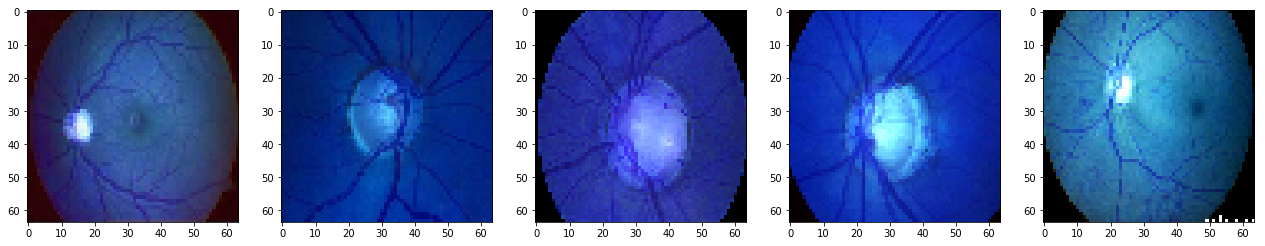

In [9]:
plt.figure(figsize=(22,13))
for i , image_index in enumerate(np.random.randint(len(parasitized_images),size=5)):
  plt.subplot(1,5,i  + 1)
  plt.imshow(dataset[image_index])

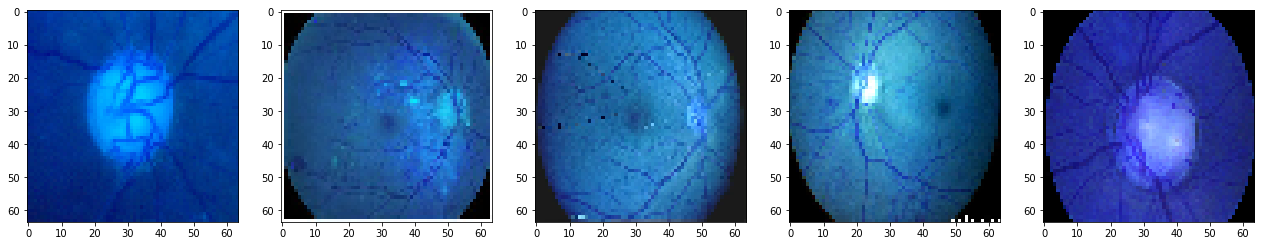

In [10]:
plt.figure(figsize=(22,13))
for i , image_index in enumerate(np.random.randint(len(uninfected_images),size=5)):
  plt.subplot(1,5,i  + 1)
  plt.imshow(dataset[image_index])

In [12]:
X = np.array(dataset)
Y= np.array(label)
print(X.shape, Y.shape)

(40, 64, 64, 3) (40,)


In [13]:
#train testsplit
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

In [14]:
#create a graph
sess = tf.Session()

In [15]:
batch_size = 10
learning_rate = 0.005
evaluation_size = 500
image_width = X_train[0].shape[0]
image_height = X_train[0].shape[1]
target_size = 1
#print(image_width,image_height,target_size)
num_channels = 3 
generations = 500
eval_every = 5
conv1_features = 25 
conv2_features = 50  
conv3_features = 75  
max_pool_size1 = 2 
max_pool_size2 = 2 
max_pool_size3 = 2 
fully_connected_size1 = 100

64 64 1


In [16]:
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)

eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))


#conv-layer parameters
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features],stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

conv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features, conv3_features],stddev=0.1, dtype=tf.float32))
conv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))


#fully-conected layer parameters 
resulting_width = image_width // (max_pool_size1 * max_pool_size2 * max_pool_size3)
resulting_height = image_height // (max_pool_size1 * max_pool_size2 * max_pool_size3)

full1_input_size = resulting_width * resulting_height * conv3_features

full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size],stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))


Instructions for updating:
Colocations handled automatically by placer.


In [17]:
def my_conv_net(input_data):
    # First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')
    
    
    # Third Conv-ReLU-MaxPool Layer
    conv3 = tf.nn.conv2d(max_pool2, conv3_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_bias))
    max_pool3 = tf.nn.max_pool(relu3, ksize=[1, max_pool_size3, max_pool_size3, 1],strides=[1, max_pool_size3, max_pool_size3, 1], padding='SAME')

    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool3.get_shape().as_list()
    #             HEIGHT                 WIDTH                 CHANNEL
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool3, [final_conv_shape[0], final_shape])

    # First Fully Connected Layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))

    # Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    
    return(final_model_output)

In [18]:
model_output = my_conv_net(x_input)
test_model_output = my_conv_net(eval_input)

In [19]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

In [20]:
# Create an optimizer
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)

In [21]:
prediction = tf.nn.sigmoid(model_output)
test_prediction = tf.nn.sigmoid(test_model_output)

In [22]:
init = tf.global_variables_initializer()
sess.run(init)


def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return(100. * num_correct/batch_predictions.shape[0])

In [23]:
# Training loop


train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(X_train), size=batch_size)
    rand_x = X_train[rand_index]
    #rand_x = np.expand_dims(rand_x, 3)
    rand_y = y_train[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if (i+1) % 50 == 0:
        eval_index = np.random.choice(len(X_test), size=evaluation_size)
        eval_x = X_test[eval_index]
        #eval_x = np.expand_dims(eval_x, 3)
        eval_y = y_test[eval_index]
        test_dict = {eval_input: eval_x, eval_target: eval_y}
        test_preds = sess.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(test_preds, eval_y)
        
        # Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
        

Generation # 50. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
Generation # 100. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
Generation # 150. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
Generation # 200. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
Generation # 250. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
Generation # 300. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
Generation # 350. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
Generation # 400. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
Generation # 450. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
Generation # 500. Train Loss: 0.00. Train Acc (Test Acc): 100.00 (100.00)
